<a href="https://colab.research.google.com/github/pinilDissanayaka/Paddy-Doctor-Paddy-Disease-Classification/blob/main/XceptionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.9 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
! kaggle datasets download ricardosalvatorelli1/paddydoctor

Dataset URL: https://www.kaggle.com/datasets/ricardosalvatorelli1/paddydoctor
License(s): unknown
 99% 1.01G/1.02G [00:20<00:00, 87.7MB/s]
100% 1.02G/1.02G [00:20<00:00, 53.7MB/s]


In [4]:
! unzip paddydoctor.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [5]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [7]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

import warnings
warnings.filterwarnings(action = 'ignore')

In [8]:
import glob
from pathlib import Path

train_path = '/content/train_images'
test_path  = '/content/test_images'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

print('test images')
for filepath in glob.glob(test_path + '/*/'):
  files = glob.glob(filepath + '*')
  print(f"{len(files)} \t {Path(filepath).name}")

files = glob.glob(test_path + '/*')
print(f"{len(files)} \t {Path(test_path).name}")

train images
1764 	 normal
1442 	 dead_heart
337 	 bacterial_panicle_blight
1738 	 blast
620 	 downy_mildew
1594 	 hispa
965 	 brown_spot
479 	 bacterial_leaf_blight
380 	 bacterial_leaf_streak
1088 	 tungro
test images
3469 	 test_images


In [9]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

10


In [10]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
8330 2077 0


In [11]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    tf.keras.utils.plot_model(back_bone, to_file='xception.png')
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)

    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy

    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.hdf5',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

In [ ]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint])

Epoch 1/100
261/261 [==============================] - ETA: 0s - loss: 1.1516 - accuracy: 0.6218
Epoch 1: val_loss improved from inf to 0.66997, saving model to xception.weights.best.hdf5
261/261 [==============================] - 251s 824ms/step - loss: 1.1516 - accuracy: 0.6218 - val_loss: 0.6700 - val_accuracy: 0.7780 - lr: 1.0000e-04
Epoch 2/100
261/261 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8601
Epoch 2: val_loss improved from 0.66997 to 0.37127, saving model to xception.weights.best.hdf5
261/261 [==============================] - 198s 759ms/step - loss: 0.4380 - accuracy: 0.8601 - val_loss: 0.3713 - val_accuracy: 0.8888 - lr: 1.0000e-04
Epoch 3/100
154/261 [================>.............] - ETA: 1:12 - loss: 0.2676 - accuracy: 0.9152

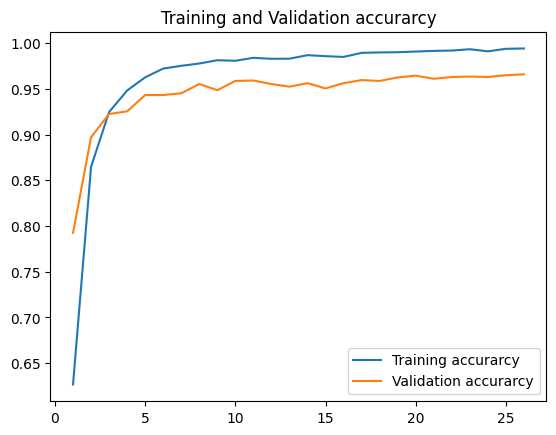

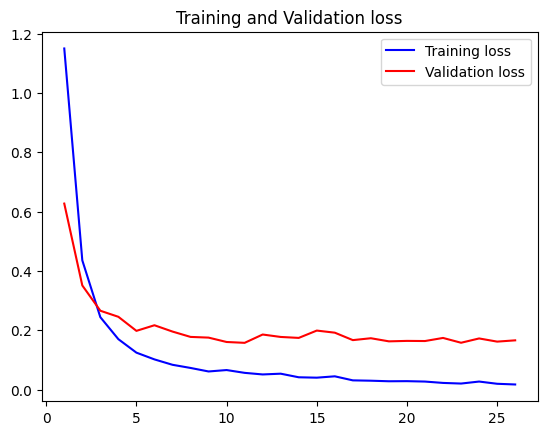

CPU times: user 981 ms, sys: 76.6 ms, total: 1.06 s
Wall time: 2.06 s


In [ ]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, label='Training accurarcy')
plt.plot(epochs, val_acc, label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print('test images')
for filepath in glob.glob(train_path+'/*'):
    files = glob.glob(filepath + '/*')
    print(f"{len(files)} \t {Path(filepath).name}")

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=train_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
1738 	 blast
965 	 brown_spot
620 	 downy_mildew
337 	 bacterial_panicle_blight
380 	 bacterial_leaf_streak
1442 	 dead_heart
479 	 bacterial_leaf_blight
1594 	 hispa
1088 	 tungro
1764 	 normal
Found 10407 images belonging to 10 classes.


In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()

model.load_weights('xception.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

10407/10407 [==============================] - 99s 10ms/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes,
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 97.87%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.98732   0.97495   0.98109       479
   bacterial_leaf_streak    0.98936   0.97895   0.98413       380
bacterial_panicle_blight    0.96802   0.98813   0.97797       337
                   blast    0.98032   0.97468   0.97750      1738
              brown_spot    0.95875   0.98756   0.97295       965
              dead_heart    0.99516   0.99792   0.99654      1442
            downy_mildew    0.92563   0.94355   0.93450       620
                   hispa    0.99041   0.97177   0.98100      1594
                  normal    0.99251   0.97619   0.98428      1764
                  tungro    0.96054   0.98438   0.97231      1088

                accuracy                        0.97867     10407
               macro avg    0.97480   0.97781   0.97623     10407
            weighted avg    0.97892   0.97867   0.97872     10407



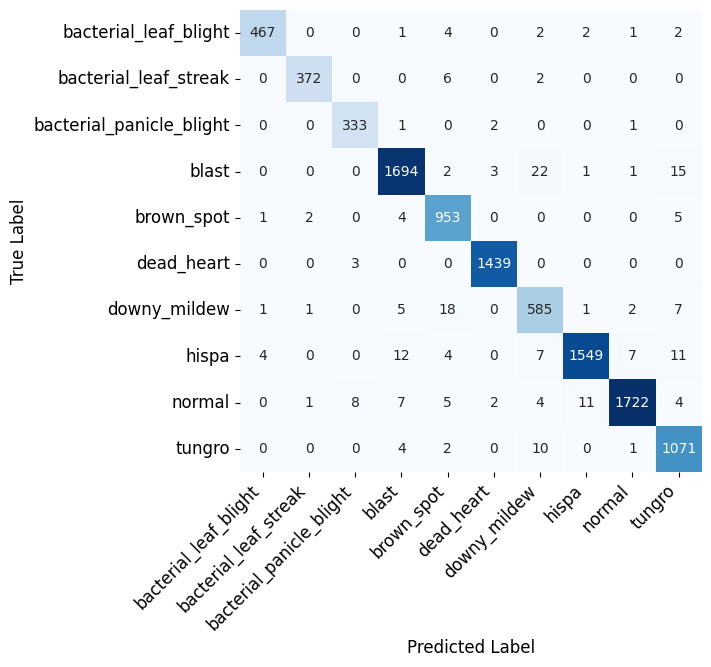

[[ 467    0    0    1    4    0    2    2    1    2]
 [   0  372    0    0    6    0    2    0    0    0]
 [   0    0  333    1    0    2    0    0    1    0]
 [   0    0    0 1694    2    3   22    1    1   15]
 [   1    2    0    4  953    0    0    0    0    5]
 [   0    0    3    0    0 1439    0    0    0    0]
 [   1    1    0    5   18    0  585    1    2    7]
 [   4    0    0   12    4    0    7 1549    7   11]
 [   0    1    8    7    5    2    4   11 1722    4]
 [   0    0    0    4    2    0   10    0    1 1071]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [ ]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

10407/10407 [==============================] - 55s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      1735
blast                       1728
hispa                       1564
dead_heart                  1446
tungro                      1115
brown_spot                   994
downy_mildew                 632
bacterial_leaf_blight        473
bacterial_leaf_streak        376
bacterial_panicle_blight     344
Name: count, dtype: int64

In [ ]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,bacterial_leaf_blight/100023.jpg,bacterial_leaf_blight
1,bacterial_leaf_blight/100049.jpg,bacterial_leaf_blight
2,bacterial_leaf_blight/100126.jpg,bacterial_leaf_blight
3,bacterial_leaf_blight/100133.jpg,bacterial_leaf_blight
4,bacterial_leaf_blight/100148.jpg,bacterial_leaf_blight
